# Improved Crystal Orientation Mapping

This notebook demonstrates improved methods for crystal orientation mapping, making use of advanced computing science concepts like:
- Parallelisation through multiprocessing
- Clustering through parallelised machine-learning
- Principle component analysus

In [8]:
import ICOM
import time
import numpy as np

## TiTaO

Results obtained by processing data from a TiTaO sample with 42x314 scan points

In [2]:
# Point this to the directory where you wish to save and load data
directory = '/home/2633941r/_Project/data_files/'

# Enter file_name.h5 of calibrated data
tatio_file_name = 'IM104 untilted_braggdisks_cali.h5'

# Create an Icom object
tatio = ICOM.Icom(directory, tatio_file_name, bps=np.load('tatio_bps.npy'))

/
|---datacube_root
    |---braggvectors
        |---_v_uncal




100%|██████████| 13188/13188 [00:25<00:00, 522.05it/s] 


### Parallelised Brute-Force Approach

We can construct a 2D distance matrix where each row corresponds to a scan-position and the nth corresponds to the abstract distance between that scan position and the nth scanposition.

This distance metric is computed by taking the 5 brightest bragg peaks of a scan position and comparing the distance between each peak and every peak in a second scan position. The distance of the closest peak to each of the 5 peaks is taken. These distances will be smaller if the scan position is a similar material and orientation. These distances are summed up and the total used as an abstract distance metric representing the similarity between 2 scan positions.

The brute-force approach compares every scan position to every other scan position, which is time-consuming but results in clear data if reasonable parameters are chosen when clustering.

This has been parallelised by splitting rows into different threads. Each thread compares the scan positions in some rows to every other scan position. When ran with 16 jobs on a server with 8 physical cores, runtime can be reduced by \~4x (~17m to ~5m with this dataset on the university server).

In [5]:
# start_t_tatio = time.time()
##################################################
# tatio.calc_dist_matrix_brute(n=5, n_jobs=-1)
#################################################
# print('Time taken:', time.time()-start_t_tatio)

Time taken: 343.5700116157532


In [7]:
# WARNING: This is ~1.3 Gb for this data-set
# tatio.save_d('tatio_d')

In [9]:
tatio.d_mat = np.load('tatio_d.npy')

### Clustering

We use the fast_hdbscan library, an implementation of the hdbscan clustering algorithm which allows significant parallelism. While the more common hdbscan library also has an n_jobs parameter, that version only parallelises a fraction of the processing rather than the entire process.

The hdb_cluster parameter for ICOM is optional but recommended for fine-tuning the algorithm to work with your dataset. Here we pass in a parameter for illustrative purposes, but these particular settings are identical to the default settings for the brute-force clustering.

In [10]:
start_t_tatio_cluster = time.time()
######################################################
hdb_cluster = ICOM.fast_hdbscan.HDBSCAN(
    min_cluster_size=100,
    n_jobs=-1,
    cluster_selection_epsilon=.1,
)

tatio.cluster_brute_force(hdb_cluster=hdb_cluster)
######################################################
print('Time taken:', time.time()-start_t_tatio_cluster)

array([-1, -1, -1, ...,  0,  0,  0])

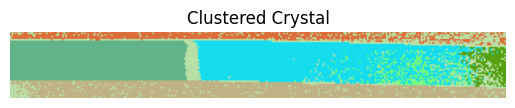

In [11]:
tatio.plot_brute_cluster()

In [6]:
tatio.calc_dist_pca()
tatio.cluster_pca()
tatio.plot_pca()

[0.4064981955345625 -0.5933521562922689] (2,)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed